In [101]:
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [102]:
import pandas as pd
import torch
from datetime import datetime, timedelta
# Đọc dữ liệu từ file CSV
df = pd.read_csv('DXG-Historical-Data.csv')

In [103]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
# Đảo ngược lại dữ liệu
df = df.iloc[::-1].reset_index(drop=True)

In [104]:
# Loại bỏ dấu phẩy từ cột "Price"
df['Price'] = df['Price'].str.replace(',', '').astype(float)
# Loại bỏ dấu phẩy từ cột "Open"
df['Open'] = df['Open'].str.replace(',', '').astype(float)
# Loại bỏ dấu phẩy từ cột "High"
df['High'] = df['High'].str.replace(',', '').astype(float)
# Loại bỏ dấu phẩy từ cột "Low"
df['Low'] = df['Low'].str.replace(',', '').astype(float)

In [105]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-01-03,6066.5,6191.4,6191.4,6041.6,494.17K,-2.80%
1,2017-01-04,6166.4,6066.5,6191.4,6041.6,2.04M,1.65%
2,2017-01-05,6091.5,6191.4,6191.4,6091.5,2.31M,-1.21%
3,2017-01-06,6141.4,6141.4,6291.2,6141.4,4.07M,0.82%
4,2017-01-09,6141.4,6141.4,6266.3,6141.4,2.86M,0.00%
...,...,...,...,...,...,...,...
1795,2024-03-14,18100.0,18200.0,18400.0,17900.0,12.18M,-0.28%
1796,2024-03-15,18300.0,18100.0,18850.0,18100.0,29.13M,1.10%
1797,2024-03-18,19000.0,18450.0,19300.0,18200.0,36.19M,3.83%
1798,2024-03-19,18500.0,19200.0,19300.0,18500.0,11.64M,-2.63%


In [106]:
# Lấy ngày cuối cùng của dữ liệu
last_date = df['Date'].max()

In [107]:
# Lấy dữ liệu Date cần phân tích để dự bảo DL trên tập test
time_series_Date = df['Date']

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra - để lấy date
train_data_Date = time_series_Date[:int(0.7 * len(time_series_Date))]
test_data_Date = time_series_Date[int(0.7 * len(time_series_Date)):]
first_data_Date = test_data_Date.min()
print(first_data_Date)

2022-01-18 00:00:00


In [108]:
# Lấy dữ liệu cần phân tích
time_series_price = df['Price']

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data_price = time_series_price[:int(0.7 * len(time_series_price))]
test_data_price = time_series_price[int(0.7 * len(time_series_price)):]

# Chọn các cột dữ liệu số
# numeric_columns = ['Price', 'Open', 'High', 'Low']
numeric_columns = ['Price']

# Chuyển các giá trị số thành tensor
numeric_data = df[numeric_columns].values.astype(np.float32)

# Mở rộng chiều để phù hợp với đầu vào của mô hình
numeric_data = np.expand_dims(numeric_data, axis=0)

# Chia dữ liệu thành tensor
input_data_train = torch.tensor(numeric_data[:, :len(train_data_price), :])
input_data_test = torch.tensor(numeric_data[:, len(train_data_price):, :])

# In ra để kiểm tra kích thước của các tensor
print("Kích thước tập huấn luyện:", input_data_train.shape)
print("Kích thước tập kiểm tra:", input_data_test.shape)

Kích thước tập huấn luyện: torch.Size([1, 1260, 1])
Kích thước tập kiểm tra: torch.Size([1, 540, 1])


In [111]:
# Khởi tạo cấu hình cho model
class Configs:
    def __init__(self):
        self.seq_len = 1260  # Độ dài chuỗi thời gian đầu vào(tập kiểm tra)
        self.pred_len = 1260  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model = Model(configs)

In [112]:
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model(input_data_train)

    # Tính toán loss
    loss = criterion(outputs, input_data_train)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 32538140.0000
Epoch [2/100], Loss: 239657456.0000
Epoch [3/100], Loss: 32057246.0000
Epoch [4/100], Loss: 49448804.0000
Epoch [5/100], Loss: 129448752.0000
Epoch [6/100], Loss: 86113824.0000
Epoch [7/100], Loss: 15672037.0000
Epoch [8/100], Loss: 10506453.0000
Epoch [9/100], Loss: 52302180.0000
Epoch [10/100], Loss: 67171640.0000
Epoch [11/100], Loss: 39588340.0000
Epoch [12/100], Loss: 9510502.0000
Epoch [13/100], Loss: 8155379.0000
Epoch [14/100], Loss: 25977664.0000
Epoch [15/100], Loss: 34638820.0000
Epoch [16/100], Loss: 24867124.0000
Epoch [17/100], Loss: 10743168.0000
Epoch [18/100], Loss: 6924179.0000
Epoch [19/100], Loss: 12392010.0000
Epoch [20/100], Loss: 16655202.0000
Epoch [21/100], Loss: 14375700.0000
Epoch [22/100], Loss: 9260902.0000
Epoch [23/100], Loss: 6670225.0000
Epoch [24/100], Loss: 7140334.0000
Epoch [25/100], Loss: 7910221.0000
Epoch [26/100], Loss: 7425177.0000
Epoch [27/100], Loss: 6335346.0000
Epoch [28/100], Loss: 5457327.5000
Epoch [29

In [113]:
# Dự báo cho tập test
# # Chuyển sang chế độ đánh giá
model.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future_test = input_data_train.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted_test = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(540):  # Dự báo cho tập test
        # Dự báo cho ngày hiện tại
        output = model(input_data_future_test)
        # Lưu dự báo của ngày hiện tại
        predicted_test.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future_test = torch.cat([input_data_future_test[:, :, 1:], output], dim=2)

    # In ra dự báo cho tập test
    print("Predicted Output for data test:")
    for i in range(540):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {first_data_Date + pd.DateOffset(days=i+1)} - Predicted: {predicted_test[i][0]}")


Predicted Output for data test:
Day 1: 2022-01-19 00:00:00 - Predicted: tensor([32117.5176])
Day 2: 2022-01-20 00:00:00 - Predicted: tensor([32104.5605])
Day 3: 2022-01-21 00:00:00 - Predicted: tensor([32094.0566])
Day 4: 2022-01-22 00:00:00 - Predicted: tensor([32083.6309])
Day 5: 2022-01-23 00:00:00 - Predicted: tensor([32073.2090])
Day 6: 2022-01-24 00:00:00 - Predicted: tensor([32062.7891])
Day 7: 2022-01-25 00:00:00 - Predicted: tensor([32052.3770])
Day 8: 2022-01-26 00:00:00 - Predicted: tensor([32041.9648])
Day 9: 2022-01-27 00:00:00 - Predicted: tensor([32031.5605])
Day 10: 2022-01-28 00:00:00 - Predicted: tensor([32021.1523])
Day 11: 2022-01-29 00:00:00 - Predicted: tensor([32010.7539])
Day 12: 2022-01-30 00:00:00 - Predicted: tensor([32000.3594])
Day 13: 2022-01-31 00:00:00 - Predicted: tensor([31989.9629])
Day 14: 2022-02-01 00:00:00 - Predicted: tensor([31979.5703])
Day 15: 2022-02-02 00:00:00 - Predicted: tensor([31969.1855])
Day 16: 2022-02-03 00:00:00 - Predicted: tensor

In [114]:
# Khởi tạo cấu hình cho model
class Configs:
    def __init__(self):
        self.seq_len = 540  # Độ dài chuỗi thời gian đầu vào(tập kiểm tra)
        self.pred_len = 540  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model = Model(configs)

In [115]:
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model(input_data_test)

    # Tính toán loss
    loss = criterion(outputs, input_data_test)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 73766696.0000
Epoch [2/100], Loss: 58498832.0000
Epoch [3/100], Loss: 24770090.0000
Epoch [4/100], Loss: 26134180.0000
Epoch [5/100], Loss: 40540500.0000
Epoch [6/100], Loss: 34816876.0000
Epoch [7/100], Loss: 18903066.0000
Epoch [8/100], Loss: 10852647.0000
Epoch [9/100], Loss: 14266670.0000
Epoch [10/100], Loss: 17908122.0000
Epoch [11/100], Loss: 15076196.0000
Epoch [12/100], Loss: 9768401.0000
Epoch [13/100], Loss: 8060266.0000
Epoch [14/100], Loss: 10195574.0000
Epoch [15/100], Loss: 11501934.0000
Epoch [16/100], Loss: 9258116.0000
Epoch [17/100], Loss: 5555513.0000
Epoch [18/100], Loss: 3777947.5000
Epoch [19/100], Loss: 4544719.5000
Epoch [20/100], Loss: 5817912.0000
Epoch [21/100], Loss: 5804153.5000
Epoch [22/100], Loss: 4646600.5000
Epoch [23/100], Loss: 3504040.5000
Epoch [24/100], Loss: 2981728.2500
Epoch [25/100], Loss: 2862382.2500
Epoch [26/100], Loss: 2761033.7500
Epoch [27/100], Loss: 2549250.5000
Epoch [28/100], Loss: 2267827.0000
Epoch [29/100], 

In [116]:
# Dự báo cho 30 ngày kế tiếp
# # Chuyển sang chế độ đánh giá
model.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_test.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(30):  # Dự báo cho 30 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 30 days:")
    for i in range(30):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {last_date + pd.DateOffset(days=i+1)} - Predicted: {predicted[i][0]}")


Predicted Output for the next 30 days:
Day 1: 2024-03-21 00:00:00 - Predicted: tensor([18708.1133])
Day 2: 2024-03-22 00:00:00 - Predicted: tensor([18707.9824])
Day 3: 2024-03-23 00:00:00 - Predicted: tensor([18707.6641])
Day 4: 2024-03-24 00:00:00 - Predicted: tensor([18707.3379])
Day 5: 2024-03-25 00:00:00 - Predicted: tensor([18707.0137])
Day 6: 2024-03-26 00:00:00 - Predicted: tensor([18706.6875])
Day 7: 2024-03-27 00:00:00 - Predicted: tensor([18706.3633])
Day 8: 2024-03-28 00:00:00 - Predicted: tensor([18706.0371])
Day 9: 2024-03-29 00:00:00 - Predicted: tensor([18705.7129])
Day 10: 2024-03-30 00:00:00 - Predicted: tensor([18705.3867])
Day 11: 2024-03-31 00:00:00 - Predicted: tensor([18705.0625])
Day 12: 2024-04-01 00:00:00 - Predicted: tensor([18704.7363])
Day 13: 2024-04-02 00:00:00 - Predicted: tensor([18704.4082])
Day 14: 2024-04-03 00:00:00 - Predicted: tensor([18704.0859])
Day 15: 2024-04-04 00:00:00 - Predicted: tensor([18703.7598])
Day 16: 2024-04-05 00:00:00 - Predicted:

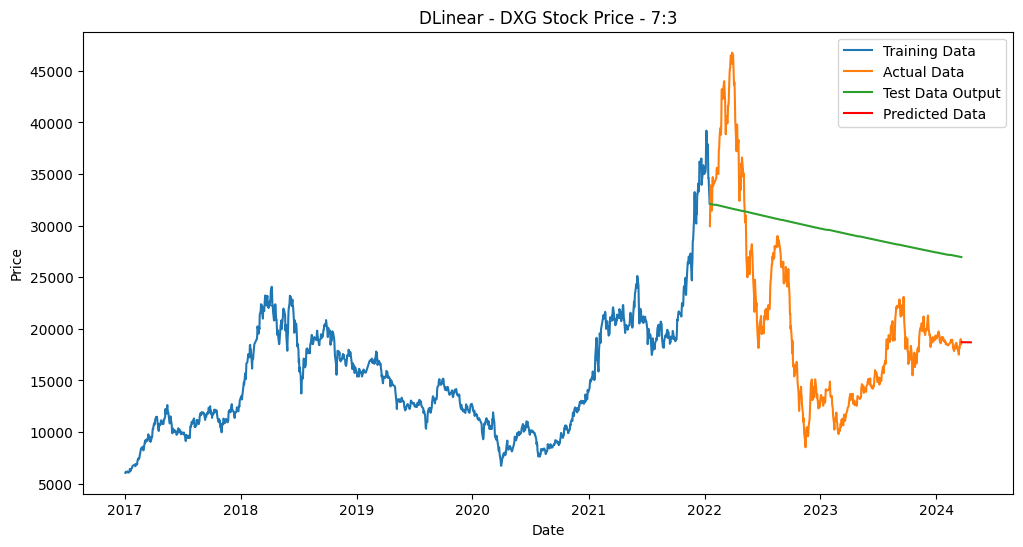

In [117]:
import matplotlib.pyplot as plt

# Chuyển dữ liệu từ Series pandas thành numpy array để vẽ biểu đồ
predicted_values_test = [pred[0].numpy() for pred in predicted_test]
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]
# Tạo mảng chứa ngày của train_data_price
train_dates = df['Date'].values[:len(train_data_price)]
# Tạo mảng chứa ngày của test_data_price
test_dates = df['Date'].values[len(train_data_price):len(train_data_price)+len(test_data_price)]
# Tạo mảng chứa ngày dự đoán
predicted_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=len(predicted_values))

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train_data_price, label='Training Data')
plt.plot(test_dates, test_data_price, label='Actual Data')
plt.plot(test_dates, predicted_values_test, label='Test Data Output')
plt.plot(predicted_dates, predicted_values, label='Predicted Data', color='red')
plt.title('DLinear - DXG Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [118]:
outputs_test = np.array(predicted_values_test)
outputs_test = outputs_test.flatten()

In [119]:
# Mean Absolute Error (MAE) và Mean Absolute Percentage Error (MAPE)
mae_test = np.mean(np.abs(test_data_price - outputs_test))
mape_test = np.mean(np.abs((test_data_price - outputs_test) / test_data_price)) * 100
rmse_test = np.sqrt(np.mean((test_data_price - outputs_test) ** 2))

print("MAE:", mae_test)
print("MAPE:", mape_test)
print("RMSE:", rmse_test)

MAE: 10762.208199508103
MAPE: 68.02447474107338
RMSE: 11804.495161333229
